# Transformer

In [27]:
import jieba

import torch.nn as nn
import torch
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# torchtext.disable_torchtext_deprecation_warning()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [3]:
def tokenizer(text):
    return [tok for tok in jieba.cut(text)]


class TextDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        # sep='\t'表示使用制表符分隔，header=0表示第一行为列名
        self.data = pd.read_csv(file_path, sep='\t', header=0)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.tokenizer(self.data.iloc[idx, 1])
        trg = self.tokenizer(self.data.iloc[idx, 0])
        return {'src': src, 'trg': trg}


# 创建词汇表
def yield_tokens(data_iter):
    for tokens in data_iter:
        # yield 的作用是将函数变成一个生成器
        yield tokens

train_data = TextDataset('../data/data_sample.tsv', tokenizer)
# train_data = TextDataset('../data/train.tsv', tokenizer)
# val_data = TextDataset('../data/dev.tsv', tokenizer)


# 使用词频生成词汇表
# min_freq=2表示只有出现次数大于等于2的词才会被加入到词汇表中
vocab = build_vocab_from_iterator(yield_tokens(item['src'] for item in train_data),
                                  min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

# 定义索引转换和特殊标记索引
PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']


def collate_batch(batch):
    src_batch, trg_batch = [], []
    for item in batch:
        # 添加起始 (SOS) 和结束 (EOS) 标记，并转换为索引
        src_batch.append([SOS_IDX] + vocab(item['src']) + [EOS_IDX])
        trg_batch.append([SOS_IDX] + vocab(item['trg']) + [EOS_IDX])

    # 使用 pad_sequence 对每个批次的序列填充到相同长度
    src_batch = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in src_batch],
                                                padding_value=PAD_IDX, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in trg_batch],
                                                padding_value=PAD_IDX, batch_first=True)
    return src_batch.to(device), trg_batch.to(device)


# 创建数据加载器
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, collate_fn=collate_batch)
# val_loader = DataLoader(val_data, batch_size=128, shuffle=False, collate_fn=collate_batch)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Cynthia\AppData\Local\Temp\jieba.cache
Loading model cost 0.802 seconds.
Prefix dict has been built successfully.


In [33]:
from sklearn.model_selection import train_test_split
# 分词器
def tokenizer(text):
    return [tok for tok in jieba.cut(text)]

# 自定义数据集类
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.tokenizer(self.data.iloc[idx, 1])
        trg = self.tokenizer(self.data.iloc[idx, 0])
        return {'src': src, 'trg': trg}

# 读取数据并划分为训练集和验证集
data = pd.read_csv('../data/data_sample.tsv', sep='\t', header=0)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 创建数据集实例
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)

# 创建词汇表
def yield_tokens(data_iter):
    for tokens in data_iter:
        yield tokens

# 使用训练数据构建词汇表
vocab = build_vocab_from_iterator(yield_tokens(item['src'] for item in train_dataset),
                                  min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

# 定义索引转换和特殊标记索引
PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']

# 批次处理函数
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for item in batch:
        src_batch.append([SOS_IDX] + vocab(item['src']) + [EOS_IDX])
        trg_batch.append([SOS_IDX] + vocab(item['trg']) + [EOS_IDX])
    
    src_batch = pad_sequence([torch.tensor(x) for x in src_batch], padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence([torch.tensor(x) for x in trg_batch], padding_value=PAD_IDX, batch_first=True)
    return src_batch.to(device), trg_batch.to(device)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

print("Vocabulary:", vocab.get_itos())  # 检查词汇表内容
print("Vocabulary size:", len(vocab))   # 检查词汇表大小


Vocabulary: ['<unk>', '<pad>', '<sos>', '<eos>', '：', '“', '”', '的', '，', '#', '！', '？', '海南', '了', '海口', '、', '你', '将', '是', '10', '也', '人', '来', '法', '要', '让', '香港', '1', '7', '不', '与', '为', '后', '吗', '啦', '在', '多', '最高', '月', '有', '看', '第一', '被', '15', '2014', '3', 'CES', '今日', '全国', '办', '去', '发布', '可', '周末', '国家', '对', '少女', '岁', '年', '年货', '我', '新', '春节', '杨桃', '男子', '等', '网信', '能', '购物', '违规', '都', '-', '2', '2015', '24', '5', '9', ':', '\xa0', '…', '一批', '三亚', '专项', '个', '主动', '之', '习', '交通事故', '产品', '人民', '代购', '们', '佩兰', '信心', '信息', '免费', '全面', '公布', '别买', '前', '加强', '千万', '只', '吃', '名', '向', '和', '场', '增至', '大', '大学生', '大桥', '失踪', '学生', '实施', '家长', '容易', '小心', '就', '展', '巡回', '工商总局', '已', '市场', '带', '平价', '开卖', '律师', '恋爱', '感动', '我们', '手机', '打造', '抗癌药', '报价', '排名', '推出', '摘', '支付', '政府', '施行', '日', '智能手机', '最高检', '未', '案件', '检方', '次', '死', '比赛', '汽车', '没', '河南', '法庭', '澄迈', '特里', '登革热', '皇马', '监督员', '称', '网上', '网站', '网络', '考虑', '者', '脱掉', '英媒', '获', '菜', '薄熙来', '街头', '西双版纳',

## Multi-head Self-attention Layer

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    # input shape: [batch size, seq len, hid dim]
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim=-1)
        # attention = [batch size, n heads, query len, key len]

        # assert(key len == value len)
        x = torch.matmul(self.dropout(attention), V)
        # x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch size, query len, hid dim]
        
        return x, attention

In [6]:
# 定义模型参数
hid_dim = 512  # 隐藏层维度
n_heads = 8    # 多头注意力头数
dropout = 0.1

# 创建 MultiHeadAttentionLayer 实例
model = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device).to(device)

# 创建测试输入
batch_size = 2      # 批量大小
query_len = 10      # query 序列长度
key_len = 10        # key 序列长度
value_len = 10      # value 序列长度

# 输入形状为 [batch size, seq len, hid dim]
query = torch.rand(batch_size, query_len, hid_dim).to(device)
key = torch.rand(batch_size, key_len, hid_dim).to(device)
value = torch.rand(batch_size, value_len, hid_dim).to(device)

# 执行前向传播并输出结果
output, attention = model(query, key, value)

print("Output shape:", output.shape)        # 预期输出形状为 [batch size, query len, hid dim]
print("Attention shape:", attention.shape)  # 预期注意力形状为 [batch size, n heads, query len, key len]

Output shape: torch.Size([2, 10, 512])
Attention shape: torch.Size([2, 8, 10, 10])


## Feed Forward Network 

In [20]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        # x = [batch size, seq len, hid dim]
        
        return x

In [9]:
# 定义参数
hid_dim = 512   # 输入特征维度
pf_dim = 2048   # 前馈网络的隐藏维度
dropout = 0.1   # dropout 概率

# 创建 PositionwiseFeedforwardLayer 实例
ff_layer = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

# 创建测试输入张量
batch_size = 2
seq_len = 10
x = torch.rand(batch_size, seq_len, hid_dim)  # [batch size, seq len, hid dim]

# 执行前向传播并打印结果
output = ff_layer(x)

print("Input shape:", x.shape)        # 期望：[batch size, seq len, hid dim]
print("Output shape:", output.shape)  # 期望：[batch size, seq len, hid dim]

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])


## Encoder Layer

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]
        
        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src = [batch size, src len, hid dim]
        
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src = [batch size, src len, hid dim]
        
        return src

In [11]:
# 定义参数
hid_dim = 512
n_heads = 8
pf_dim = 2048
dropout = 0.1

# 创建 EncoderLayer 实例
encoder_layer = EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device).to(device)

# 创建测试输入
batch_size = 2
src_len = 10

# 输入数据和掩码
src = torch.rand(batch_size, src_len, hid_dim).to(device)         # [batch size, src len, hid dim]
src_mask = torch.ones(batch_size, 1, 1, src_len).to(device)       # [batch size, 1, 1, src len]

# 执行前向传播
output = encoder_layer(src, src_mask)

print("Input shape:", src.shape)       # 预期：[batch size, src len, hid dim]
print("Output shape:", output.shape)   # 预期：[batch size, src len, hid dim]

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])


## Encoder

In [22]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            # src = [batch size, src len, hid dim]
        
        return src

In [13]:
# Parameters for testing
input_dim = 1000  # Vocabulary size
hid_dim = 512     # Embedding/hidden size
n_layers = 1      # Number of encoder layers
n_heads = 1       # Number of attention heads
pf_dim = 2048     # Position-wise feedforward dimension
dropout = 0.1     # Dropout probability
src_len = 10      # Length of source sequence
batch_size = 2    # Batch size

# Initialize encoder with test parameters
encoder = Encoder(input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device).to(device)

# Create random test input
src = torch.randint(0, input_dim, (batch_size, src_len)).to(device)  # Random integers representing token IDs
src_mask = torch.ones((batch_size, 1, 1, src_len)).to(device)        # Simple mask with ones

# Test the encoder
output = encoder(src, src_mask)
print("Input shape:", src.shape)       # 预期：[batch size, src len]
print("Output shape:", output.shape)   # 预期：[batch size, src len, hid dim]

1000
Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 512])


## Decoder Layer

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]
        
        # encoder attention
        # input: [query, key, value, mask]
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # attention = [batch size, n heads, trg len, src len]
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]
        
        return trg, attention

In [15]:
# Parameters for testing
hid_dim = 512     # Hidden dimension
n_heads = 1       # Number of attention heads
pf_dim = 2048     # Position-wise feedforward dimension
dropout = 0.1     # Dropout probability
trg_len = 10      # Length of target sequence
src_len = 15      # Length of source sequence
batch_size = 2    # Batch size

# Initialize decoder layer with test parameters
decoder_layer = DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device).to(device)

# Create random test input
trg = torch.rand(batch_size, trg_len, hid_dim).to(device)  # Target sequence
enc_src = torch.rand(batch_size, src_len, hid_dim).to(device)  # Encoder source output
trg_mask = torch.ones((batch_size, 1, trg_len, trg_len)).to(device)  # Target mask
src_mask = torch.ones((batch_size, 1, 1, src_len)).to(device)  # Source mask

# Test the decoder layer
output, attention = decoder_layer(trg, enc_src, trg_mask, src_mask)
print("Input shape:", src.shape)       # 预期：[batch size, src len]
print("Output shape:", output.shape)   # 预期：[batch size, src len, hid dim]

Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 512])


## Decoder

In [24]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            # trg = [batch size, trg len, hid dim]
            # attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        # output = [batch size, trg len, output dim]
        
        return output, attention

In [17]:
# Parameters for testing
output_dim = 1000  # Output vocabulary size
hid_dim = 512      # Hidden dimension
n_layers = 1       # Number of decoder layers
n_heads = 1        # Number of attention heads
pf_dim = 2048      # Position-wise feedforward dimension
dropout = 0.1      # Dropout probability
trg_len = 10       # Length of target sequence
src_len = 15       # Length of source sequence
batch_size = 2     # Batch size

# Initialize decoder with test parameters
decoder = Decoder(output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device).to(device)

# Create random test input
trg = torch.randint(0, output_dim, (batch_size, trg_len)).to(device)  # Target sequence token IDs
enc_src = torch.rand(batch_size, src_len, hid_dim).to(device)         # Encoder output
trg_mask = torch.ones((batch_size, 1, trg_len, trg_len)).to(device)   # Target mask
src_mask = torch.ones((batch_size, 1, 1, src_len)).to(device)         # Source mask

# Test the decoder
output, attention = decoder(trg, enc_src, trg_mask, src_mask)
print("Input shape:", trg.shape)       # 预期：[batch size, src len]
print("Output shape:", output.shape)   # 预期：[batch size, src len, hid dim]

Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 1000])


## Transformer

In [25]:
class Transformer(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 pad_idx,
                 device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src = [batch size, src len]
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch size, 1, 1, src len]
        return src_mask

    def make_trg_mask(self, trg):
        # trg = [batch size, trg len]
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        # trg_sub_mask = [trg len, trg len]
        
        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        # src = [batch size, src len]
        # trg = [batch size, trg len]
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch size, src len, hid dim]
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [13]:
# Parameters for testing
input_dim = 1000  # Vocabulary size
hid_dim = 512     # Embedding/hidden size
n_layers = 1      # Number of encoder layers
n_heads = 1       # Number of attention heads
pf_dim = 2048     # Position-wise feedforward dimension
dropout = 0.1     # Dropout probability
src_len = 10      # Length of source sequence
batch_size = 2    # Batch size


# Initialize encoder, decoder, and transformer
encoder = Encoder(input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device).to(device)
decoder = decoder = Decoder(output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device).to(device)
transformer = Transformer(encoder, decoder, 0, device)

# Create random test inputs
src = torch.randint(0, output_dim, (batch_size, src_len))  # Random source sequence
trg = torch.randint(0, output_dim, (batch_size, trg_len))  # Random target sequence

# Test the transformer
output, attention = transformer(src, trg)
src.shape, output.shape

NameError: name 'output_dim' is not defined

In [38]:
from collections import Counter

# 定义分词器
def tokenizer(text):
    return [tok for tok in jieba.cut(text)]


# 自定义数据集类
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.tokenizer(self.data.iloc[idx, 1])
        trg = self.tokenizer(self.data.iloc[idx, 0])
        return {'src': src, 'trg': trg}


# 读取数据并划分为训练集和验证集
data = pd.read_csv('../data/data_sample.tsv', sep='\t', header=0)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 创建数据集实例
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)


# 构建词汇表
def build_vocab(data, min_freq=2):
    counter = Counter()
    for item in data:
        counter.update(item['src'])
        # counter.update(item['trg'])
    # 过滤低频词，只保留频率大于等于min_freq的词
    filtered_words = [word for word, freq in counter.items() if freq >= min_freq]

    # 为词汇表创建连续的索引，从4开始编号，保留特殊标记
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    vocab.update({word: idx for idx, word in enumerate(filtered_words, start=4)})

    return vocab


# 创建词汇表
vocab = build_vocab(train_dataset, min_freq=2)

# 定义索引转换和特殊标记索引
PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']


# 批次处理函数
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for item in batch:
        src = [vocab.get(token, UNK_IDX) for token in item['src']]
        trg = [vocab.get(token, UNK_IDX) for token in item['trg']]
        src_batch.append([SOS_IDX] + src + [EOS_IDX])
        trg_batch.append([SOS_IDX] + trg + [EOS_IDX])

    src_batch = pad_sequence([torch.tensor(x) for x in src_batch], padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence([torch.tensor(x) for x in trg_batch], padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

print("Vocabulary:", vocab)  # 检查词汇表内容
print("Vocabulary size:", len(vocab))   # 检查词汇表大小

Vocabulary: {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '三亚': 4, '遭': 5, '了': 6, '？': 7, '海南': 8, '发布': 9, '工商总局': 10, '与': 11, '：': 12, '政府': 13, '要': 14, '加强': 15, '对': 16, '的': 17, '大': 18, '\xa0': 19, '“': 20, '”': 21, '，': 22, '！': 23, '在': 24, '信息': 25, '7': 26, '来': 27, '路': 28, '人': 29, '2': 30, '场': 31, '佩兰': 32, '也': 33, '没': 34, '信心': 35, '3': 36, '最高检': 37, ':': 38, '未': 39, '是': 40, '排名': 41, '最高': 42, '英媒': 43, '报价': 44, '感动': 45, '2014': 46, '一批': 47, '交通事故': 48, '公布': 49, '习': 50, '有': 51, '法': 52, '第一': 53, '巡回': 54, '法庭': 55, '今日': 56, '多': 57, '部门': 58, '、': 59, '等': 60, '后': 61, '比赛': 62, '只': 63, '脱掉': 64, '推出': 65, '你': 66, '看': 67, '5': 68, '网络': 69, '者': 70, '都': 71, '小心': 72, '律师': 73, '称': 74, '可': 75, '名': 76, '车祸': 77, '遇难': 78, '网信': 79, '办': 80, '账号': 81, '将': 82, '施行': 83, '网站': 84, '违规': 85, '手机': 86, '去': 87, '智能手机': 88, '市场': 89, '1': 90, '主动': 91, '新': 92, '春节': 93, '前': 94, '皇马': 95, '开卖': 96, '为': 97, '问题': 98, '-': 99, '免费': 100, '啦': 101, '千万

[Eval Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s, loss=1.81]


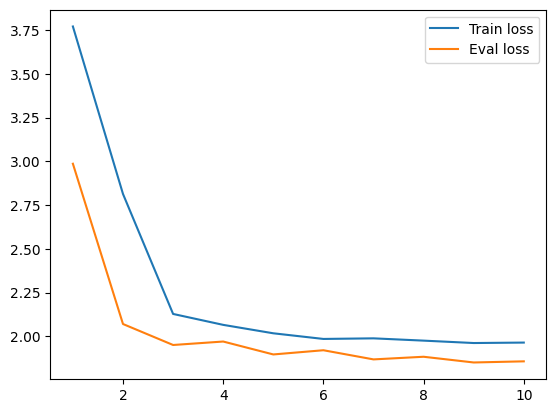

In [39]:
# Model hyperparameters
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
HID_DIM = 512
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 2048
DEC_PF_DIM = 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
N_EPOCHS = 10
CLIP = 1

# Instantiate encoder, decoder, and transformer model
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)
model = Transformer(enc, dec, PAD_IDX, device).to(device)


# Xavier 均匀分布初始化权重 weights
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


model.apply(initialize_weights)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Track loss values for training and evaluation
loss_vals = []
loss_vals_eval = []

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = []

    # 添加进度条显示
    pbar = tqdm(train_loader)
    pbar.set_description(f"[Train Epoch {epoch}]")

    for src, trg in pbar:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        # trg[:, :-1] 去掉了目标序列中的最后一个位置，以确保模型只能看到部分的 trg 序列，并生成下一个单词。
        # trg[:, 1:] 去掉了目标序列中的第一个位置，让模型逐步学习如何从已生成的部分生成下一个单词。
        # trg = [<sos>, "I", "love", "NLP", <eos>]
        # trg[:, :-1] = [<sos>, "I", "love", "NLP"]
        # trg[:, 1:]  = ["I", "love", "NLP", <eos>]
        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # output = [batch_size * (trg_len - 1), output_dim]
        trg = trg[:, 1:].contiguous().view(-1)
        # trg = [batch_size * (trg_len - 1)]

        # 模型中没有显式使用 softmax，但在损失计算时通过 CrossEntropyLoss 完成了 softmax 转换。
        loss = criterion(output, trg)
        loss.backward()

        # 执行梯度裁剪，限制每个参数梯度的最大范数为 CLIP，防止梯度爆炸。
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        epoch_loss.append(loss.item())
        pbar.set_postfix(loss=loss.item())

    loss_vals.append(np.mean(epoch_loss))

    # Evaluate the model
    model.eval()
    epoch_loss_eval = []
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"[Eval Epoch {epoch}")

        for src, trg in pbar:
            src, trg = src.to(device), trg.to(device)
            output, _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss_eval.append(loss.item())
            pbar.set_postfix(loss=loss.item())

    loss_vals_eval.append(np.mean(epoch_loss_eval))

# Save model
# torch.save(model.state_dict(), 'model.pt')

# Plot the training and evaluation losses
l1, = plt.plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), loss_vals)
l2, = plt.plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), loss_vals_eval)
plt.legend(handles=[l1, l2], labels=['Train loss', 'Eval loss'], loc='best')
# plt.legend(handles=[l1], labels=['Train loss'], loc='best')
plt.show()

In [41]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
HID_DIM = 512
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 2048
DEC_PF_DIM = 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# 初始化编码器、解码器和Transformer模型
# enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
# dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)
# model = Transformer(enc, dec, PAD_IDX, device).to(device)

# 加载预训练模型
# model.load_state_dict(torch.load('model.pt'))
model.eval()

# 输入句子并分词
sent = '中新网9月19日电据英国媒体报道,当地时间19日,苏格兰公投结果出炉,55%选民投下反对票,对独立说“不”。在结果公布前,英国广播公司(BBC)预测,苏格兰选民以55%对45%投票反对独立。'
tokens = [tok for tok in jieba.cut(sent)]
tokens = ['<sos>'] + tokens + ['<eos>']

# 将分词转换为词汇表索引
src_indexes = [vocab.get(token, UNK_IDX) for token in tokens]
src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
src_mask = model.make_src_mask(src_tensor)

# 编码输入句子
with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)

# 初始化目标序列的索引列表
trg_indexes = [SOS_IDX]

# 逐步生成翻译结果
for i in range(50):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    trg_mask = model.make_trg_mask(trg_tensor)

    with torch.no_grad():
        output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

    pred_token = output.argmax(2)[:,-1].item()
    trg_indexes.append(pred_token)

    if pred_token == EOS_IDX:
        break

# 将目标序列的索引转换回词汇表的词汇
trg_tokens = [list(vocab.keys())[list(vocab.values()).index(i)] for i in trg_indexes]

# 输出结果（去除<sos>标记）
print(trg_tokens[1:])

['等', '佩兰', '等', '佩兰', '等', '佩兰', '等', '佩兰', '等', '佩兰', '等', '手机', '：', '遇难', '市场', '之', '周末', '在', '遇难', '市场', '吗', '车祸', '信心', '9', '！', '手机', '：', '遇难', '比赛', '在', '今日', '能', '7', '人', '在', '今日', '吃', '推出', '手机', '：', '遇难', '比赛', '在', '今日', '让', '千万', '：', '遇难', '比赛', '在']
